In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Login to wandb
!wandb login

wandb: Currently logged in as: miloszbertman to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
import os
import random

import numpy as np
import pandas as pd
import torch

# Import our custom modules
from config import Config
from dataset import create_data_loaders
from metrics import plot_roc_curves, plot_precision_recall_curves
from model import create_model, setup_model_for_training, count_parameters
from trainer import Trainer


def set_seed(seed: int) -> None:
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# Set random seed for reproducibility
set_seed(42)

# Check if CUDA is available
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print(f"CUDA Version: {torch.version.cuda}")
print(f"PyTorch Version: {torch.__version__}")

Using device: cpu
CUDA Version: None
PyTorch Version: 2.9.0


In [4]:
# Create configuration object
config = Config()
config.info()

Configuration:
  train_size_perc: 0.8
  test_size_perc: 0.2
  dataset_src: ./fn-content-dataset/compiled
  label_dataframe: ./fn-content-dataset/compiled/action_labels.csv
  output_dir: ./outputs
  seed: 42
  batch_size: 32
  num_workers: 5
  threshold: 0.5
  img_size: 224
  model_name: convnextv2_tiny
  learning_rate: 1e-05
  epochs: 20
  early_stopping_patience: 10
  early_stopping_min_delta: 0.001
  lr_reduce_patience: 5
  lr_reduce_factor: 0.5
  lr_reduce_min_lr: 1e-07
  use_class_weights: True
  class_weight_method: inverse_freq
  loss_type: focal
  use_wandb: False
  wandb_project: fn-content-classifier
  wandb_entity: miloszbertman
  wandb_run_name: None
  wandb_tags: None
  model_catalog: {'convnextv2_nano': 224, 'convnextv2_tiny': 224, 'convnextv2_base': 224, 'convnextv2_large': 224, 'convnextv2_huge': 224}


In [5]:
# Enable wandb logging
config.use_wandb = False
config.wandb_tags = [config.model_name]
config.wandb_config()

Wandb is disabled.


In [8]:
# Updated Dataset Loading with Label Distribution Data
# ===================================================

print("Loading and preparing dataset with distribution data...")

# Create data loaders with stratified splitting (updated signature)
train_loader, val_loader, label_columns, original_labels, train_labels, test_labels = create_data_loaders(config)

print(f"Dataset loaded successfully!")
print(f"  Number of classes: {len(label_columns)}")
print(f"  Class names: {label_columns}")
print(f"  Training samples: {len(train_loader.dataset)}")
print(f"  Validation samples: {len(val_loader.dataset)}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

# Display sample batch info
sample_batch = next(iter(train_loader))
images, labels = sample_batch
print(f"\nSample batch shape:")
print(f"  Images: {images.shape}")
print(f"  Labels: {labels.shape}")
print(f"  Label range: [{labels.min():.3f}, {labels.max():.3f}]")
print(f"  Positive labels per sample: {labels.sum(dim=1).float().mean():.2f}")

# Store the label data for later use
print(f"\nLabel distribution data available:")
print(f"  Original labels shape: {original_labels.shape}")
print(f"  Train labels shape: {train_labels.shape}")
print(f"  Test labels shape: {test_labels.shape}")


Loading and preparing dataset with distribution data...
Dataset loaded successfully!
  Number of classes: 19
  Class names: ['69', 'anal_fucking', 'ass_licking', 'ass_penetration', 'fingering', 'grabbing_ass', 'grabbing_boobs', 'grabbing_hair/head', 'handjob', 'kissing', 'masturbation', 'pussy_rubbing', 'vaginal_fucking', 'vaginal_penetration', 'vibrating', 'wet_genitals', 'blowjob', 'cum', 'pussy_licking']
  Training samples: 73476
  Validation samples: 18386
  Training batches: 2297
  Validation batches: 575


/Users/milosz/Projects/fn-poc-classifier/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Sample batch shape:
  Images: torch.Size([32, 3, 224, 224])
  Labels: torch.Size([32, 19])
  Label range: [0.000, 1.000]
  Positive labels per sample: 2.56

Label distribution data available:
  Original labels shape: (91862, 19)
  Train labels shape: (73476, 19)
  Test labels shape: (18386, 19)


Creating label distribution visualization...
Label distribution plot saved to: ./outputs/label_distribution.png


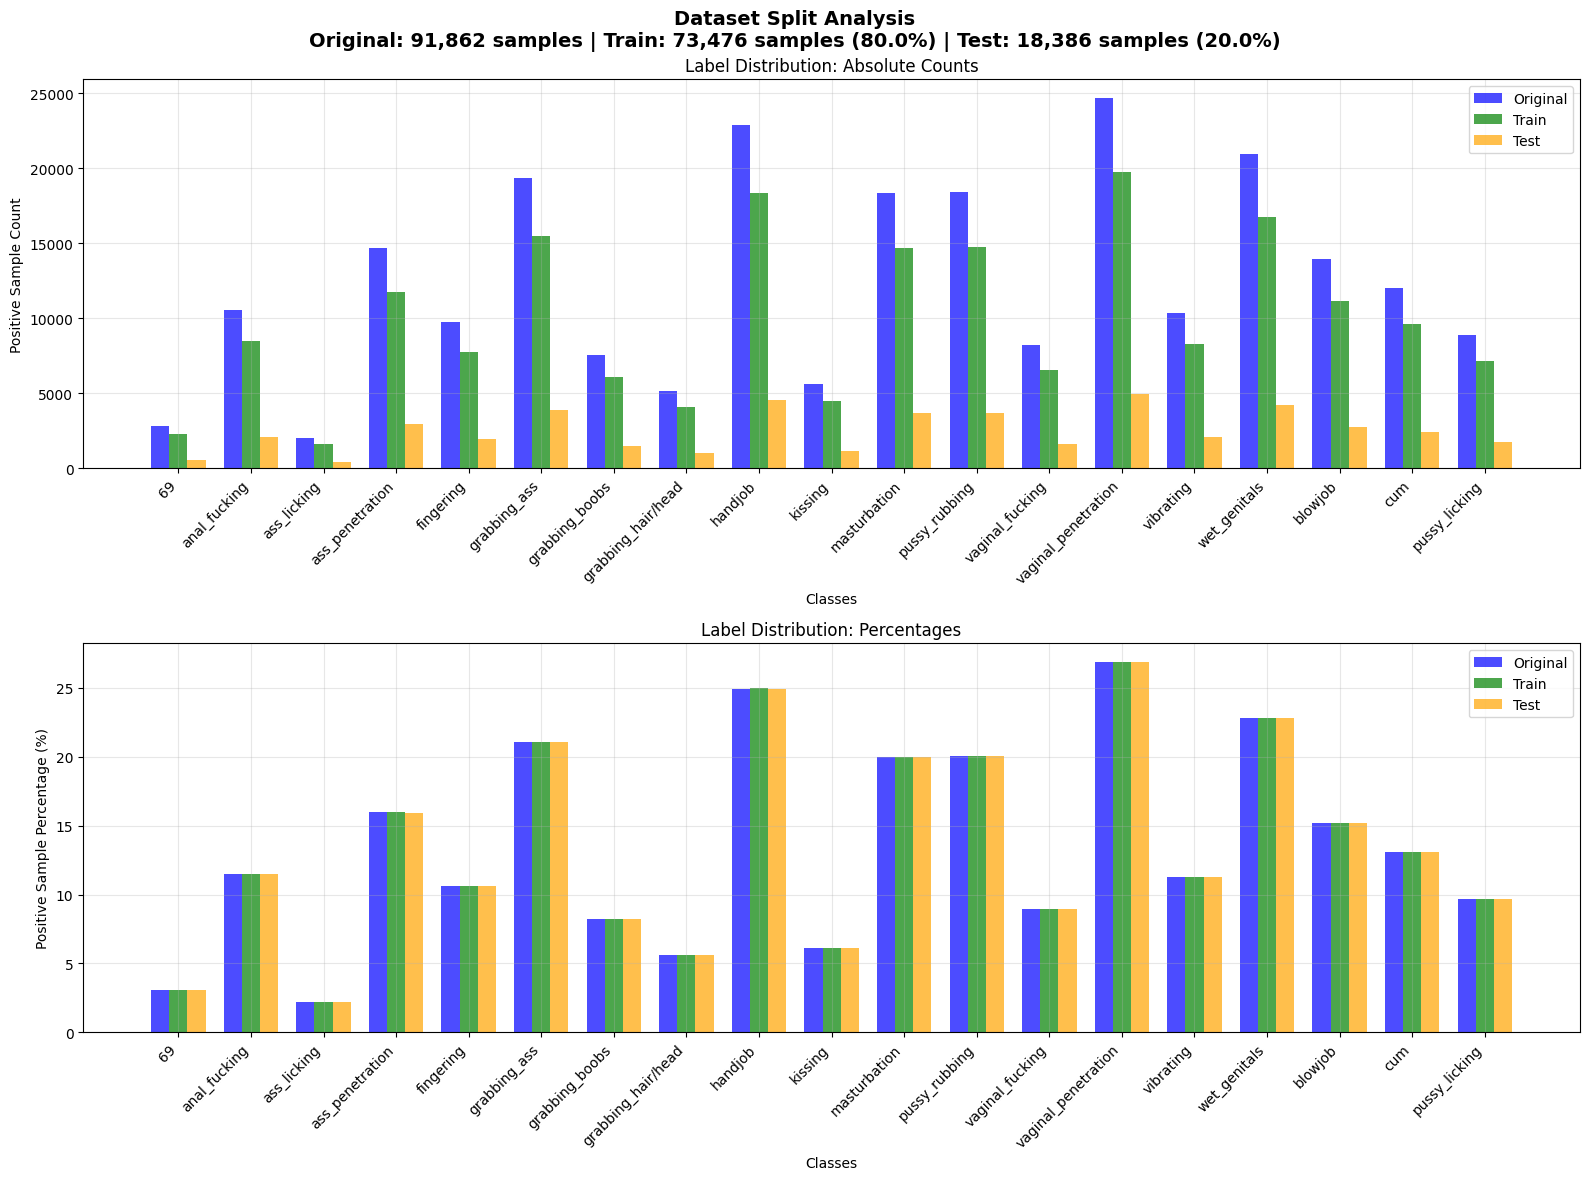


DETAILED LABEL DISTRIBUTION ANALYSIS
Class                Original     Train        Test         Train%   Test%   
--------------------------------------------------------------------------------
69                   2828.0       2262.0       566.0        3.08     3.08    
anal_fucking         10577.0      8462.0       2115.0       11.52    11.50   
ass_licking          2048.0       1639.0       409.0        2.23     2.22    
ass_penetration      14655.0      11724.0      2931.0       15.96    15.94   
fingering            9734.0       7787.0       1947.0       10.60    10.59   
grabbing_ass         19349.0      15479.0      3870.0       21.07    21.05   
grabbing_boobs       7584.0       6067.0       1517.0       8.26     8.25    
grabbing_hair/head   5154.0       4124.0       1030.0       5.61     5.60    
handjob              22907.0      18326.0      4581.0       24.94    24.92   
kissing              5638.0       4510.0       1128.0       6.14     6.14    
masturbation         18

In [13]:
# Label Distribution Visualization
# ===============================

print("Creating label distribution visualization...")

# Import the visualization function
from dataset import plot_label_distribution

# Create the visualization
plot_label_distribution(
    original_labels=original_labels,
    train_labels=train_labels,
    test_labels=test_labels,
    label_columns=label_columns,
    save_path=os.path.join(config.output_dir, 'label_distribution.png')
)

print("Label distribution analysis completed!")


In [ ]:
# Class Imbalance Analysis and Configuration
# ==========================================

print("Analyzing class imbalance and configuring class weights...")

# Show current configuration
print(f"\nClass Weight Configuration:")
print(f"  Use class weights: {config.use_class_weights}")
print(f"  Class weight method: {config.class_weight_method}")
print(f"  Loss function: {config.loss_type}")

# Calculate and display class weights if enabled
if config.use_class_weights:
    from losses import print_class_weights

    # Get training labels
    train_labels = train_loader.dataset.labels

    # Print class weights analysis
    class_weights = print_class_weights(
        train_labels,
        label_columns,
        method=config.class_weight_method
    )

    # Store class weights for later use
    config.class_weights = class_weights

    print(f"\nClass weights calculated and stored in config.class_weights")
    print(f"Class weights shape: {class_weights.shape}")
    print(f"Class weights device: {class_weights.device if hasattr(class_weights, 'device') else 'CPU'}")

else:
    print("\nClass weights are disabled. Set config.use_class_weights = True to enable.")
    print("Available class weight methods:")
    print("  - 'inverse_freq': Inverse frequency weighting (default)")
    print("  - 'balanced': Balanced weighting (sklearn style)")
    print("  - 'sqrt_inverse_freq': Square root of inverse frequency")

print(f"\nAvailable loss functions:")
print("  - 'focal': Focal Loss (good for class imbalance)")
print("  - 'asymmetric': Asymmetric Loss")
print("  - 'weighted_bce': Weighted Binary Cross Entropy")
print("  - 'bce': Standard Binary Cross Entropy")


In [ ]:
# Model Creation and Setup
# =========================

print("Creating and setting up model...")

# Create model
model = create_model(
    config=config,
    num_classes=len(label_columns)
)

# Setup model for training (freeze/unfreeze based on training mode)
model = setup_model_for_training(
    model=model,
    config=config
)

# Count parameters
param_counts = count_parameters(model)
print(f"Model created successfully!")
print(f"  Total parameters: {param_counts['total']:,}")
print(f"  Trainable parameters: {param_counts['trainable']:,}")
print(f"  Frozen parameters: {param_counts['frozen']:,}")
print(f"  Training mode: Finetuning (backbone frozen, classifier trainable)")

# Move model to device
model = model.to(device)
print(f"  Model moved to: {device}")

# Test forward pass
print("\nTesting forward pass...")
with torch.no_grad():
    sample_images = torch.randn(2, 3, config.img_size, config.img_size).to(device)
    sample_output = model(sample_images)
    print(f"  Input shape: {sample_images.shape}")
    print(f"  Output shape: {sample_output.shape}")
    print(f"  Output range: [{sample_output.min():.3f}, {sample_output.max():.3f}]")

# Show class weight configuration
print(f"\nClass Weight Configuration:")
print(f"  Use class weights: {config.use_class_weights}")
print(f"  Class weight method: {config.class_weight_method}")
print(f"  Loss function: {config.loss_type}")
if hasattr(config, 'class_weights') and config.class_weights is not None:
    print(f"  Class weights calculated: Yes")
    print(f"  Class weights shape: {config.class_weights.shape}")
else:
    print(f"  Class weights calculated: No")

In [ ]:
# Training Setup
# ==============

print("Setting up trainer...")

# Create trainer
trainer = Trainer(
    model=model,
    config=config,
    train_loader=train_loader,
    val_loader=val_loader,
    label_columns=label_columns,
    device=str(device)
)

print("Trainer setup complete!")
print(f"  Loss function: {config.loss_type}")
print(f"  Class weights: {'Enabled' if config.use_class_weights else 'Disabled'}")
if config.use_class_weights:
    print(f"  Class weight method: {config.class_weight_method}")
print(f"  Optimizer: AdamW (lr={config.learning_rate})")
print(f"  Scheduler: ReduceLROnPlateau (patience={config.lr_reduce_patience})")
print(f"  Early stopping: Enabled (patience={config.early_stopping_patience})")
print(f"  Mixed precision: Enabled")
print(f"  Threshold: {config.threshold}")
print(f"  Training mode: Finetuning")

In [ ]:
# Training Execution
# ==================

print("Starting training...")
print("=" * 50)

# Start training
history = trainer.train()

print("=" * 50)
print("Training completed!")
print(f"Best validation F1 Micro: {trainer.best_val_f1:.4f}")

# Plot training history
print("\nPlotting training history...")
trainer.plot_training_history(save_path=os.path.join(config.output_dir, 'training_history.png'))


In [ ]:
# Model Evaluation and Analysis
# =============================

print("Evaluating model on validation set...")

# Get final validation metrics
val_loss, val_metrics = trainer.validate_epoch()

print("\nFinal Validation Metrics:")
print(f"  Loss: {val_loss:.4f}")
print(f"  F1 Micro: {val_metrics['f1_micro']:.4f}")
print(f"  F1 Macro: {val_metrics['f1_macro']:.4f}")
print(f"  F1 Samples: {val_metrics['f1_samples']:.4f}")
print(f"  Precision Micro: {val_metrics['precision_micro']:.4f}")
print(f"  Precision Macro: {val_metrics['precision_macro']:.4f}")
print(f"  Recall Micro: {val_metrics['recall_micro']:.4f}")
print(f"  Recall Macro: {val_metrics['recall_macro']:.4f}")

if 'roc_auc_micro' in val_metrics:
    print(f"  ROC AUC Micro: {val_metrics['roc_auc_micro']:.4f}")
    print(f"  ROC AUC Macro: {val_metrics['roc_auc_macro']:.4f}")
    print(f"  PR AUC Micro: {val_metrics['pr_auc_micro']:.4f}")
    print(f"  PR AUC Macro: {val_metrics['pr_auc_macro']:.4f}")

# Get per-class metrics
print("\nComputing per-class metrics...")
per_class_metrics = trainer.metrics_calculator.compute_per_class_metrics(
    y_true=val_loader.dataset.labels,
    y_pred=np.concatenate([trainer.model(torch.tensor(batch[0]).to(device)).cpu().detach().numpy()
                           for batch in val_loader]),
    class_names=label_columns
)

print("\nPer-class F1 Scores:")
for class_name, metrics in per_class_metrics.items():
    print(f"  {class_name}: {metrics['f1']:.4f} (support: {metrics['support']})")


In [ ]:
# Visualization and Analysis
# ===========================

print("Generating visualizations...")

# Get predictions for visualization
trainer.model.eval()
all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = trainer.model(images)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        predictions = outputs.cpu().numpy()
        labels_np = labels.cpu().numpy()

        all_predictions.append(predictions)
        all_labels.append(labels_np)
        all_probabilities.append(probabilities)

all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_probabilities = np.concatenate(all_probabilities, axis=0)

# Plot ROC curves
print("Plotting ROC curves...")
plot_roc_curves(
    all_labels,
    all_probabilities,
    label_columns,
    save_path=os.path.join(config.output_dir, 'roc_curves.png')
)

# Plot Precision-Recall curves
print("Plotting Precision-Recall curves...")
plot_precision_recall_curves(
    all_labels,
    all_probabilities,
    label_columns,
    save_path=os.path.join(config.output_dir, 'pr_curves.png')
)


In [ ]:
# Model Saving
# ============

print("Saving model and results...")

# Create output directory
os.makedirs(config.output_dir, exist_ok=True)

# Save model
model_path = os.path.join(config.output_dir, f'{config.model_name}_finetuned_best.pth')
trainer.save_model(model_path)

# Save training history as CSV
history_df = pd.DataFrame(history)
history_path = os.path.join(config.output_dir, 'training_history.csv')
history_df.to_csv(history_path, index=False)
print(f"Training history saved to: {history_path}")

# Save configuration
config_path = os.path.join(config.output_dir, 'config.json')
import json

with open(config_path, 'w') as f:
    config_dict = {
        'model_name': config.model_name,
        'training_mode': 'finetuning',
        'learning_rate': config.learning_rate,
        'epochs': config.epochs,
        'batch_size': config.batch_size,
        'img_size': config.img_size,
        'threshold': config.threshold,
        'label_columns': label_columns,
        'best_val_f1': trainer.best_val_f1
    }
    json.dump(config_dict, f, indent=2)
print(f"Configuration saved to: {config_path}")

print(f"\nAll files saved to: {config.output_dir}")
print("Training completed successfully!")


In [ ]:
from utils import visualize_predictions

visualize_predictions(
    model=trainer.model,
    test_images=val_loader.dataset.images,
    test_labels=val_loader.dataset.labels,
    label_columns=label_columns,
    threshold=config.threshold,
    num_samples=5,
)